Import useful libraries

In [63]:
import numpy as np
from matplotlib import pyplot as plt 
from pandas import read_csv
import sys
import os
from matplotlib import rcParams
import toml

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Block spin analysis

Specify folders from which to get configurations and set the values of the yukawa couling used in the simulations

In [64]:
################################################################################
# dataset 1
folders = ["dataset1/s_0_25/conf" + str(i+1) for i in range(10)] 
folders += ["dataset1/s_0_5/conf" + str(i+1) for i in range(10)] 
folders += ["dataset1/s_1_0/conf" + str(i+1) for i in range(10)]

# dataset 2
'''folders = ["dataset2/s_0_5/conf" + str(i+1) for i in range(10)] 
folders += ["dataset2/s_1_0/conf" + str(i+1) for i in range(10)]'''

Nt0 = 16
Nx0 = 16
################################################################################

Import functions from Jan Philipp's code

In [65]:
from correlations import *
from read_in_data import *
from mass_fit import *
from mass_matteo import *

Load data from specified folders

In [66]:
phi = {}
cond = {}
absphi = {}
chi2 = {}
mr = {}
mqphys = {}
cutoffs = []

for f in folders:
    print(f)
    params = toml.load("data/" + f + "/input.toml") # read toml file with parameters

    s = str(params['physics']['cutFraction']) # read cutoff
    # if cutoff is not already in the list, add it and create the corresponding data arrays
    if not (float(s) in cutoffs):
        cutoffs.append(float(s))
        phi[s] = []
        cond[s] = []
        chi2[s] = []
        mr[s] = []
        mqphys[s] = []

    Nt = int(Nt0 / float(s))
    Nx = int(Nx0 / float(s))
    volume = (Nt, Nx)
    
    g = float(params['fermions']['yukawa_coupling']) # read yukawa coupling
    if g == 0:
        g = 1e-5
    
    print("cutFractions:", s, " Yukawa:", g)

    data = read_csv("data/" + f + "/traces.csv") # read file with magnetisation, condensate, ...

    # Get bosonic time slices computed in main.cu
    S_t = get_time_slices_from_timeslicefile("data/" + f + "/slice.dat", field_axis=0, return_all=False)
    # Get fermionic time slices computed in main.cu
    data_Sq_t = read_csv("data/" + f + "/data.csv")
    Sq_t = data_Sq_t['corr'].to_numpy(np.dtype('f8')).reshape((-1, Nt))

    # magnetisation
    val, err = get_mag(data['sigma'].to_numpy())
    phi[s].append((val, err, g))
    # condensate
    val, err = get_mag(data['tr'].to_numpy())
    cond[s].append((val, err, g))
    # susceptibility
    val, err = get_chi2(data['sigma'].to_numpy())
    chi2[s].append((val, err, g))
    # renormalised bosonic mass
    val, err = get_ren_mass_right_via_timeslices(S_t,volume)
    mr[s].append((val, err, g))
    # physical quark mass
    val, err = get_phys_quark_mass_via_timeslices(Sq_t,volume)
    print(s, g, val, err)
    mqphys[s].append((val, err, g))
    
    print()

for k in phi.keys():
    phi[k] = sorted(phi[k], key=lambda x: x[2])
    cond[k] = sorted(cond[k], key=lambda x: x[2])
    chi2[k] = sorted(chi2[k], key=lambda x: x[2])
    mr[k] = sorted(mr[k], key=lambda x: x[2])
    mqphys[k] = sorted(mqphys[k], key=lambda x: x[2])

dataset1/s_0_25/conf1
cutFractions: 0.25  Yukawa: 1e-05


100%|████████████████████████████████████| 9951/9951 [00:00<00:00, 91888.74it/s]


0.25 1e-05 0.18232165460854027 0.009751562336909821

dataset1/s_0_25/conf2
cutFractions: 0.25  Yukawa: 0.01


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 92563.21it/s]


0.25 0.01 0.1824241858635072 0.009712078307337633

dataset1/s_0_25/conf3
cutFractions: 0.25  Yukawa: 0.02


100%|████████████████████████████████████| 9951/9951 [00:00<00:00, 91053.22it/s]


0.25 0.02 0.182852752559547 0.009567558160143484

dataset1/s_0_25/conf4
cutFractions: 0.25  Yukawa: 0.1


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 91649.08it/s]


0.25 0.1 0.1977847502358892 0.0057603878441981485

dataset1/s_0_25/conf5
cutFractions: 0.25  Yukawa: 0.2


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 90553.36it/s]


0.25 0.2 0.24403717575531764 0.0012191125871669937

dataset1/s_0_25/conf6
cutFractions: 0.25  Yukawa: 1.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 89883.49it/s]


0.25 1.0 0.9586032445142111 6.440990104693364e-14

dataset1/s_0_25/conf7
cutFractions: 0.25  Yukawa: 2.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 91344.57it/s]


0.25 2.0 0.0 0.0

dataset1/s_0_25/conf8
cutFractions: 0.25  Yukawa: 10.0


100%|████████████████████████████████████| 9948/9948 [00:00<00:00, 85857.66it/s]


0.25 10.0 0.0 0.0

dataset1/s_0_25/conf9
cutFractions: 0.25  Yukawa: 20.0


100%|████████████████████████████████████| 9946/9946 [00:00<00:00, 85509.61it/s]


0.25 20.0 0.0 0.0

dataset1/s_0_25/conf10
cutFractions: 0.25  Yukawa: 100.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 85477.23it/s]


0.25 100.0 0.0 0.0

dataset1/s_0_5/conf1
cutFractions: 0.5  Yukawa: 1e-05


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 91730.32it/s]


0.5 1e-05 0.18232114529698387 0.1797678886609421

dataset1/s_0_5/conf2
cutFractions: 0.5  Yukawa: 0.01


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 89091.33it/s]


0.5 0.01 0.1824922002629946 0.17924243167749815

dataset1/s_0_5/conf3
cutFractions: 0.5  Yukawa: 0.1


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 90137.25it/s]


0.5 0.1 0.20066845348924509 0.13116576718812797

dataset1/s_0_5/conf4
cutFractions: 0.5  Yukawa: 1.0


100%|████████████████████████████████████| 9948/9948 [00:00<00:00, 83586.79it/s]


0.5 1.0 0.988435309709675 1.8886597885455568e-07

dataset1/s_0_5/conf5
cutFractions: 0.5  Yukawa: 10.0


100%|████████████████████████████████████| 9952/9952 [00:00<00:00, 89598.33it/s]


0.5 10.0 0.0 0.0

dataset1/s_0_5/conf6
cutFractions: 0.5  Yukawa: 0.02


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 88498.87it/s]


0.5 0.02 0.183023781246084 0.17761229391224417

dataset1/s_0_5/conf7
cutFractions: 0.5  Yukawa: 0.2


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 90221.64it/s]


0.5 0.2 0.25309929890079635 0.05326190724162104

dataset1/s_0_5/conf8
cutFractions: 0.5  Yukawa: 2.0


100%|████████████████████████████████████| 9948/9948 [00:00<00:00, 86837.04it/s]


0.5 2.0 1.5955757481193944 6.14737849434649e-12

dataset1/s_0_5/conf9
cutFractions: 0.5  Yukawa: 20.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 91558.44it/s]


0.5 20.0 0.0 0.0

dataset1/s_0_5/conf10
cutFractions: 0.5  Yukawa: 100.0


100%|████████████████████████████████████| 9951/9951 [00:00<00:00, 91942.99it/s]


0.5 100.0 -0.0001980097375419668 -0.0020101100444788827

dataset1/s_1_0/conf1
cutFractions: 1.0  Yukawa: 1e-05


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 91803.57it/s]


1.0 1e-05 0.18232309093930493 0.7354404126932114

dataset1/s_1_0/conf2
cutFractions: 1.0  Yukawa: 0.01


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 91384.80it/s]


1.0 0.01 0.18261041144221535 0.733656937163666

dataset1/s_1_0/conf3
cutFractions: 1.0  Yukawa: 0.1


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 86203.08it/s]


1.0 0.1 0.20299510241820506 0.6184087924028787

dataset1/s_1_0/conf4
cutFractions: 1.0  Yukawa: 1.0


100%|████████████████████████████████████| 9951/9951 [00:00<00:00, 89365.86it/s]


1.0 1.0 1.0216475371020806 0.00039511485617187516

dataset1/s_1_0/conf5
cutFractions: 1.0  Yukawa: 10.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 91860.09it/s]


1.0 10.0 0.0 0.0

dataset1/s_1_0/conf6
cutFractions: 1.0  Yukawa: 0.02


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 93750.15it/s]


1.0 0.02 0.18325792813920969 0.7297563577187429

dataset1/s_1_0/conf7
cutFractions: 1.0  Yukawa: 0.2


100%|████████████████████████████████████| 9951/9951 [00:00<00:00, 86878.41it/s]


1.0 0.2 0.2602518756447944 0.37627861777538546

dataset1/s_1_0/conf8
cutFractions: 1.0  Yukawa: 2.0


100%|████████████████████████████████████| 9952/9952 [00:00<00:00, 88809.51it/s]


1.0 2.0 1.6348331298152459 1.5881787934229e-06

dataset1/s_1_0/conf9
cutFractions: 1.0  Yukawa: 20.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 91116.62it/s]


1.0 20.0 0.0 0.0

dataset1/s_1_0/conf10
cutFractions: 1.0  Yukawa: 100.0


100%|████████████████████████████████████| 9953/9953 [00:00<00:00, 87382.43it/s]

1.0 100.0 0.0 0.0



In [67]:
'''IMPORTANT: should I use the one for large t, small t or the whole? 
tmp_ren = []
tmp_large_t = []
tmp_small_t = []

S_t = get_time_slices_from_timeslicefile("data/sim1/slice.dat")
tmp_ren = get_ren_mass_right_via_timeslices(S_t,volume)
tmp_large_ = get_masses_from_large_t(S_t, volume, [0,0,0,0],inc_in_fit=3, with_plot = False)
tmp_small_t = get_masses_from_small_t(S_t, volume, [0,0,0,0],inc_in_fit=3, with_plot = False)

ren_masses = tmp_ren
print("ren mass:", val, err)'''

'IMPORTANT: should I use the one for large t, small t or the whole? \ntmp_ren = []\ntmp_large_t = []\ntmp_small_t = []\n\nS_t = get_time_slices_from_timeslicefile("data/sim1/slice.dat")\ntmp_ren = get_ren_mass_right_via_timeslices(S_t,volume)\ntmp_large_ = get_masses_from_large_t(S_t, volume, [0,0,0,0],inc_in_fit=3, with_plot = False)\ntmp_small_t = get_masses_from_small_t(S_t, volume, [0,0,0,0],inc_in_fit=3, with_plot = False)\n\nren_masses = tmp_ren\nprint("ren mass:", val, err)'

# Plot Stuff

### Plot of the magnetization

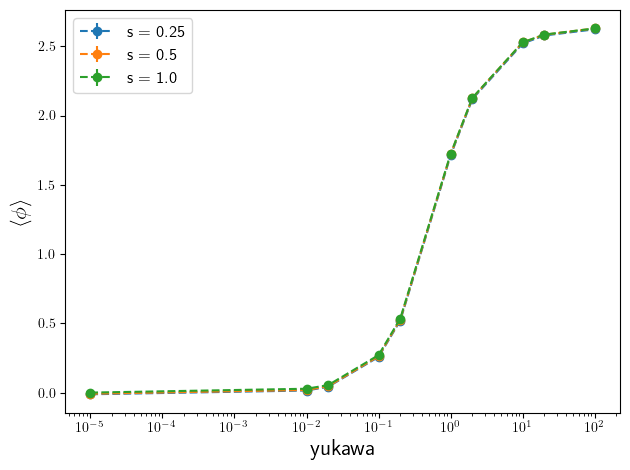

In [68]:
for k in phi.keys():
    plt.errorbar([v[2] for v in phi[k]], [v[0] for v in phi[k]], [v[1] for v in phi[k]], fmt='o--', label='s = ' + str(k))

plt.legend(fontsize=12)
plt.xscale('log')
plt.xlabel('yukawa', fontsize=16)
plt.ylabel(r'$\left\langle \phi \right\rangle$', fontsize=16)
plt.tight_layout()
plt.show()

### Plot of the magnetic susceptibility

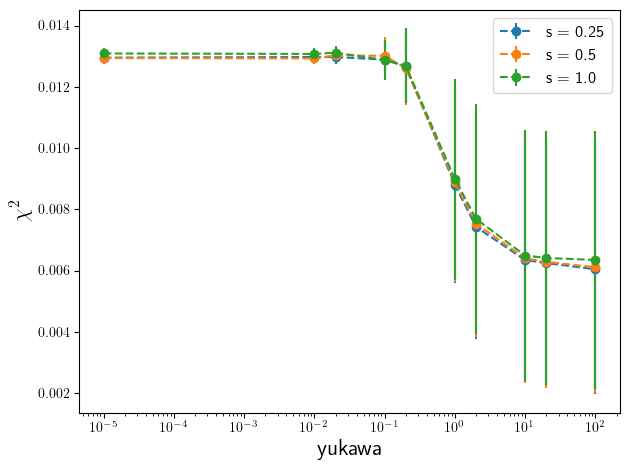

In [69]:
for k in chi2.keys():
    plt.errorbar([v[2] for v in chi2[k]], [v[0] for v in chi2[k]], [v[1] for v in chi2[k]], fmt='o--', label='s = ' + str(k))

plt.legend(fontsize=12)
plt.xscale('log')
plt.xlabel('yukawa', fontsize=16)
plt.ylabel(r'$\chi^2$', fontsize=16)
plt.tight_layout()
plt.show()

### Plot of the condensate

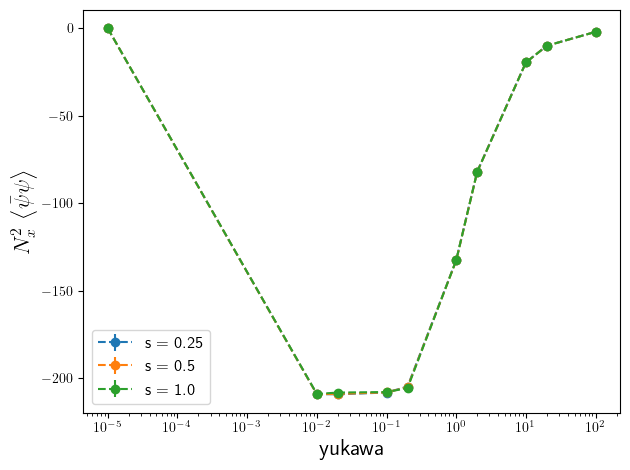

In [70]:
for k in cond.keys():
    Nx = Nx0/float(k)
    plt.errorbar([v[2] for v in cond[k]], [Nx*Nx*v[0] for v in cond[k]], [Nx*Nx*v[1] for v in cond[k]], fmt='o--', label='s = ' + str(k))

plt.legend(fontsize=12)
plt.xscale('log')
plt.xlabel('yukawa', fontsize=16)
plt.ylabel(r'$N_x^2 \, \left\langle \bar \psi \psi \right\rangle$', fontsize=16)
plt.tight_layout()
plt.show()

### Plot of the physical quark mass

[1e-05, 0.01, 0.02, 0.1, 0.2, 1.0, 2.0, 10.0, 20.0, 100.0]
[1e-05, 0.01, 0.02, 0.1, 0.2, 1.0, 2.0, 10.0, 20.0, 100.0]
[1e-05, 0.01, 0.02, 0.1, 0.2, 1.0, 2.0, 10.0, 20.0, 100.0]


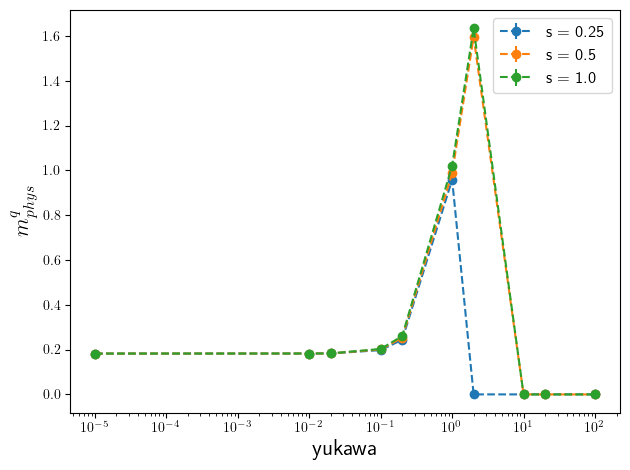

In [71]:
for k in mr.keys():
    Nx = Nx0/float(k)
    plt.errorbar([v[2] for v in mqphys[k]], [v[0] for v in mqphys[k]], [0 for _ in range(len(mqphys[k]))], fmt='o--', label='s = ' + str(k))

plt.legend(fontsize=12)
plt.xscale('log')
plt.xlabel('yukawa', fontsize=16)
plt.ylabel(r'$m^q_{phys}$', fontsize=16)
plt.tight_layout()
plt.show()

### Plot of the bosonic renormalised mass

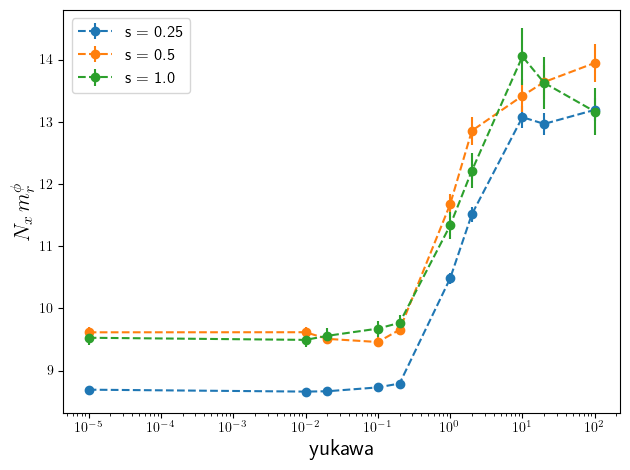

In [72]:
for k in mr.keys():
    Nx = Nx0/float(k)
    plt.errorbar([v[2] for v in mr[k]], [Nx*v[0] for v in mr[k]], [Nx*v[1] for v in mr[k]], fmt='o--', label='s = ' + str(k))

plt.legend(fontsize=12)
plt.xscale('log')
plt.xlabel('yukawa', fontsize=16)
plt.ylabel(r'$N_x \, m^\phi_r$', fontsize=16)
plt.tight_layout()
plt.show()

# Physical quark mass

In [78]:
from scipy.optimize import curve_fit as fit

####################################################
data_folder = "dataset1/s_1_0/conf1"
Nt = 16
plot = True
####################################################

def fitfuncSinh(x, m_re, A):
    return A * np.sinh(m_re*(Nt/2-x))

def fitToSinh(ydata, startidx, endidx, plot=False):
    yvals = ydata[startidx:endidx]
    xvals = np.array(range(startidx, endidx))

    fitparams = fit(fitfuncSinh, xvals, yvals, p0=[1e-2, 0])
    #print("Mass: ", abs(fitparams[0][0]))
        
    return fitparams[0]

params = toml.load("data/" + data_folder + "/input.toml") # read toml file with parameters
s = params['physics']['cutFraction'] # read cutoff
g = params['fermions']['yukawa_coupling']

print("s:", s, " g:", g)
print("Number of data points:", timeslices.shape[0])
print("Nt:", timeslices.shape[1])

data = read_csv("data/" + data_folder + "/data.csv")
timeslices = data['corr'].to_numpy(np.dtype('f8')).reshape((-1, Nt))

corr = np.average(timeslices, axis=0)

fitparams = fitToSinh(corr, 1, Nt, plot)

print("Mass =", fitparams[0])

s: 1.0  g: 0.0
Number of data points: 9950
Nt: 64
Mass = 0.18232309093919968


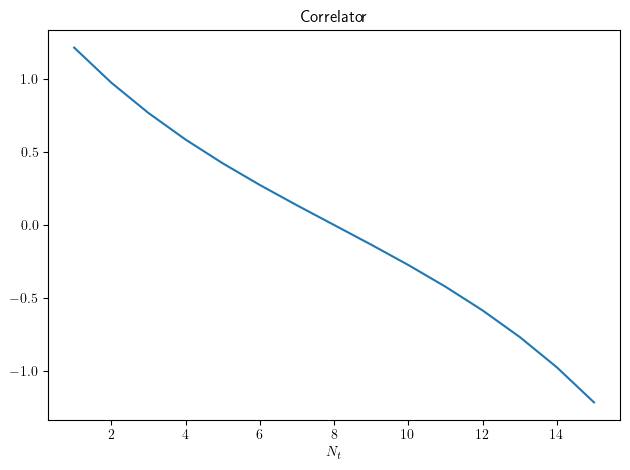

In [79]:
plt.plot(range(1, Nt), corr[1:Nt])
plt.xlabel(r'$N_t$')
plt.title("Correlator")
plt.tight_layout()
plt.savefig("mass.pdf")
plt.show()

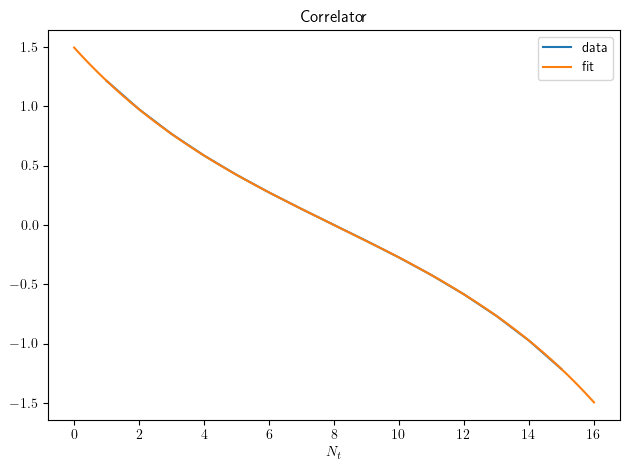

In [80]:
plt.plot(range(1, Nt), corr[1:Nt], label="data")
xvals = np.linspace(0, Nt, 1000)
plt.plot(xvals, fitfuncSinh(xvals, fitparams[0], fitparams[1]), label='fit')
plt.legend()
plt.xlabel(r'$N_t$')
plt.title("Correlator")
plt.tight_layout()
plt.savefig("mass.pdf")
plt.show()

Compute expected mass from background fields

In [43]:
def expectedM(m0, g, sigma, pi):
    r2 = sigma**2 + pi[0]**2 + pi[1]**2 + pi[2]**2
    denom = 2*(g*sigma + m0 + 1)
    sqrroot = np.sqrt((g**2*r2 + 2*m0*(g*sigma + 1) + 2*g*sigma + m0**2 + 2)**2 - 4*(g*sigma+m0+1)**2)
    num = -sqrroot + g**2*r2 + 2*g*m0*sigma + 2*g*sigma + m0**2 + 2*m0 + 2
    return -np.log(num/denom)

mq0 = 0.2
yukawa_coupling = 0.1
sigma = 0.16
pi = [0, 0, 0]

print("Expected mass with phi =", np.concatenate(([sigma], pi)), ":", expectedM(mq0, yukawa_coupling, sigma, pi))

Expected mass with phi = [0.16 0.   0.   0.  ] : 0.1955667835439752


# Renormalised boson mass

In [15]:
from correlations import *
from read_in_data import *
from mass_fit import *

In [18]:
####################################################
f = "dataset1/s_1_0/conf1"
Nt = 16
Nx = 16
####################################################
volume = (Nt, Nx)

In [19]:
S_t = get_time_slices_from_timeslicefile("data/" + f + "/slice.dat", field_axis=0, return_all=False)
val, err = get_phys_quark_mass_via_timeslices(S_t,volume)
print("mr:", val, err)

mr: 0.0013150514487019747 -0.09677968339107819


# Mean Field equations of motion

Reset data arrays

In [11]:
sigma_vals = []
sigma_errs = []
tr_vals = []
tr_errs = []
cutFractions = []

In [22]:
rcParams['text.usetex'] = True

####################################################
folders = ["s1"]
mypath = "data/"
plot_trace = True
####################################################


c = 0
for fold in folders:
    s = []
    data = [] # each element will be a triple (s, sigma, err_sigma)
    data_trace = [] # each element will be a triple (s, condensate, err_condensate)
    for f in os.listdir(mypath + fold):
        
        full_path = mypath + fold + "/" + f + "/"   
        
        params = toml.load(full_path + "/input.toml")
        s = float(params['physics']['cutFraction'])
       
        filedata = read_csv(full_path + "traces.csv")
        N = len(filedata['sigma'])
    
        # vals
        sigma = np.average(filedata['sigma'].to_numpy())
        tr = np.average(filedata['tr'].to_numpy())
        
        print("s =", s, " <|sigma|> = ", sigma, " <|psibar psi|> = ", tr)
        
        # errs
        sigma_err = np.std(filedata['sigma'].to_numpy()) / np.sqrt(N-1)
        tr_err = np.std(filedata['tr'].to_numpy()) / np.sqrt(N-1)
                    
        data.append((s, sigma, sigma_err))
        data_trace.append((s, tr, tr_err))
    
    data = sorted(data, key=lambda x: x[0])
    data_trace = sorted(data_trace, key=lambda x: x[0])
                    
    for el in data:
        cutFractions.append(el[0])
        sigma_vals.append(el[1])
        sigma_errs.append(el[2])
    
    for el in data_trace:
        tr_vals.append(el[1])
        tr_errs.append(el[2])

    plt.errorbar(cutFractions, sigma_vals, yerr=sigma_errs, fmt='o', color=colors[c])
    if plot_trace:
        plt.errorbar(cutFractions, [t/1 for t in tr_vals], yerr=[t/1 for t in tr_errs], fmt='o')

    c += 1
                    
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: 'data/conf1/slice.dat'